# Fooling an MNIST Network: CMA-ME with Constraints in Discrete Behavior Spaces

[Nguyen 2015](http://anhnguyen.me/project/fooling/) demonstrated that it is

(brief overview of fooling networks; show some examples)

In [ ]:
%pip install ribs torch torchvision tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import tqdm

from ribs.archives import GridArchive
from ribs.emitters import GaussianEmitter
from ribs.optimizers import Optimizer

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# MNIST Network

We'll quickly train a [LeNet-5](https://en.wikipedia.org/wiki/LeNet) to classify MNIST. If you are not familiar with PyTorch, we recommend referring to the [PyTorch 60-minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). Feel free to skip to the next section, where we demonstrate how to fool the network.

First, we'll load the MNIST dataset and preprocess it.

In [4]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000

MEAN_TRANSFORM = 0.1307
STD_DEV_TRANSFORM = 0.3081

# Transform each image by turning it into a tensor and then
# normalizing the values.
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAINLOADER = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=mnist_transforms),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
)
TESTLOADER = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=False,
                               transform=mnist_transforms),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
)

This is our training function. We use Cross-Entropy loss and Adam optimization.

In [5]:
def fit(net, epochs):
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        print(f"=== Epoch {epoch + 1} ===")
        total_loss = 0.0

        # Iterate through batches in the (shuffled) training dataset.
        for batch_i, data in enumerate(TRAINLOADER):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (batch_i + 1) % 100 == 0:
                print(f"Batch {batch_i + 1:5d}: {total_loss}")
                total_loss = 0.0

Now we define the LeNet-5 and train it for 2 epochs.

In [6]:
LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) output probabilities
).to(device)

fit(LENET5, 2)

=== Epoch 1 ===
Batch   100: 99.99703425168991
Batch   200: 32.97790027409792
Batch   300: 22.156265281140804
Batch   400: 19.20062405616045
Batch   500: 14.219707526266575
Batch   600: 11.086082716472447
Batch   700: 10.897964057512581
Batch   800: 9.623986646533012
Batch   900: 9.851186977699399
=== Epoch 2 ===
Batch   100: 8.467262960970402
Batch   200: 7.545613776892424
Batch   300: 6.79837516322732
Batch   400: 7.876437698490918
Batch   500: 5.7939532527234405
Batch   600: 7.334225965663791
Batch   700: 5.62374312710017
Batch   800: 5.4459550539031625
Batch   900: 5.769105343380943


To see how well the network does, we'll evaluate it on the train and test sets.

In [7]:
def evaluate(net, loader):
    correct_per_num = [0 for _ in range(10)]
    total_per_num = [0 for _ in range(10)]

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.to("cpu"), 1)
            c = (predicted == labels).squeeze()
            for i in range(len(c)):
                label = labels[i]
                correct_per_num[label] += c[i].item()
                total_per_num[label] += 1

    for i in range(10):
        print(f"Correct {i:2d}: {correct_per_num[i] / total_per_num[i]:5.3f}"
              f" ({correct_per_num[i]} / {total_per_num[i]})")
    print(f"TOTAL     : {sum(correct_per_num) / sum(total_per_num):5.3f}"
          f" ({sum(correct_per_num)} / {sum(total_per_num)})")

In [8]:
evaluate(LENET5, TRAINLOADER)

Correct  0: 0.996 (5897 / 5923)
Correct  1: 0.989 (6665 / 6742)
Correct  2: 0.991 (5903 / 5958)
Correct  3: 0.982 (6019 / 6131)
Correct  4: 0.993 (5799 / 5842)
Correct  5: 0.990 (5369 / 5421)
Correct  6: 0.996 (5894 / 5918)
Correct  7: 0.973 (6093 / 6265)
Correct  8: 0.972 (5689 / 5851)
Correct  9: 0.944 (5616 / 5949)
TOTAL     : 0.982 (58944 / 60000)


In [9]:
evaluate(LENET5, TESTLOADER)

Correct  0: 0.994 (974 / 980)
Correct  1: 0.984 (1117 / 1135)
Correct  2: 0.991 (1023 / 1032)
Correct  3: 0.989 (999 / 1010)
Correct  4: 0.993 (975 / 982)
Correct  5: 0.987 (880 / 892)
Correct  6: 0.989 (947 / 958)
Correct  7: 0.966 (993 / 1028)
Correct  8: 0.976 (951 / 974)
Correct  9: 0.940 (948 / 1009)
TOTAL     : 0.981 (9807 / 10000)


## Fooling MNIST

Above, we trained a reasonably high-performing network. We will now show how to generate images that make the network believe it is seeing various digits.

TODO: Explain behavior space, objective

In [10]:
img_size = (28, 28)
flat_img_size = 784

archive = GridArchive([10], [(0, 10)])
emitters = [
    # Original image pixels are in range (0, 1).
    GaussianEmitter(np.full(flat_img_size, 0.5),
                    0.5,
                    archive,
                    bounds=(0, 1),
                    batch_size=64)
]
optimizer = Optimizer(archive, emitters)

for i in tqdm.tqdm(range(10_000)):
    sols = optimizer.ask()

    with torch.no_grad():
        imgs = sols.reshape((-1, 1, *img_size))
        imgs = (imgs - MEAN_TRANSFORM) / STD_DEV_TRANSFORM  # Normalize.
        imgs = torch.tensor(imgs, dtype=torch.float32, device=device)
        output = LENET5(imgs)
        scores, predicted = torch.max(output.to("cpu"), 1)
        scores = torch.exp(scores)
        objs = scores.numpy()
        bcs = predicted.numpy()

    optimizer.tell(objs, bcs)

100%|██████████| 10000/10000 [00:47<00:00, 208.78it/s]


In [11]:
archive.as_pandas()

,index-0,behavior-0,objective,solution-0,solution-1,solution-2,solution-3,solution-4,solution-5,solution-6,...,solution-774,solution-775,solution-776,solution-777,solution-778,solution-779,solution-780,solution-781,solution-782,solution-783
0,8,8.0,0.995369,0.000000,0.322513,0.000000,0.271043,0.428017,0.312295,0.000000,...,0.623808,0.350374,0.464346,1.000000,0.187183,0.000000,0.000000,0.592700,0.684503,0.000000
1,2,2.0,0.996705,0.000000,1.000000,0.290462,0.365013,0.000000,0.000000,1.000000,...,0.449058,0.616369,0.000000,0.502451,0.000000,0.000000,0.000000,0.000000,0.000000,0.880889
2,9,9.0,0.916423,0.773365,1.000000,1.000000,0.558356,1.000000,0.604365,1.000000,...,1.000000,0.531263,0.000000,0.410715,1.000000,0.956049,0.000000,0.556327,0.362797,1.000000
3,0,0.0,0.967432,0.000000,0.000000,0.452829,0.000000,0.840260,0.845448,1.000000,...,0.895452,0.456560,1.000000,0.807093,0.000000,0.739520,0.154092,0.678832,1.000000,0.086422
4,3,3.0,0.993251,0.546699,0.000000,0.000000,0.000000,0.000000,0.000000,0.165840,...,0.057974,0.000000,0.764989,1.000000,0.152514,0.000000,0.338802,0.511065,0.647415,0.061699
5,7,7.0,0.908211,1.000000,0.000000,1.000000,0.821823,0.311152,0.000000,0.908594,...,1.000000,0.407896,0.000000,0.302900,0.889723,0.000000,0.000000,1.000000,0.571394,0.000000
6,6,6.0,0.948977,1.000000,0.000000,1.000000,0.795384,1.000000,0.120911,0.721252,...,0.854590,0.066820,0.000000,0.000000,0.363486,0.892959,0.459028,0.230033,1.000000,0.176198
7,5,5.0,0.983792,0.400872,1.000000,0.803370,0.365701,0.057730,1.000000,0.927794,...,1.000000,0.729963,0.000000,0.217177,0.229099,0.890952,0.579251,0.796614,0.039743,0.000000
8,4,4.0,0.982247,1.000000,0.417041,1.000000,0.460632,0.000000,1.000000,0.130869,...,0.932255,1.000000,1.000000,0.380958,1.000000,0.000000,0.995187,0.000000,1.000000,0.208153
9,1,1.0,0.636942,1.000000,1.000000,0.390825,0.000000,0.334618,0.672435,1.000000,...,0.692097,0.221107,0.830279,0.000000,0.507545,1.000000,0.020248,0.223831,0.219540,1.000000


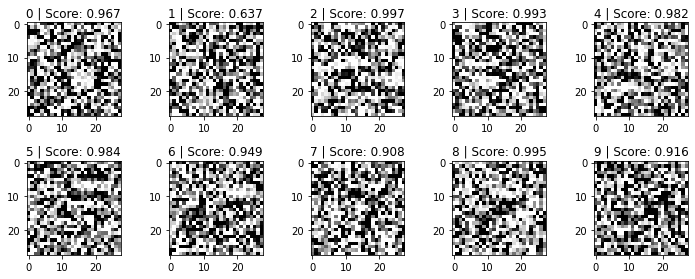

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()
ax = ax.flatten()
found = set()
for _, row in archive.as_pandas().iterrows():
    i = int(row.loc["index-0"])
    found.add(i)
    obj = row.loc["objective"]
    ax[i].set_title(f"{i} | Score: {obj:.3f}")
    img = row.loc["solution-0":].to_numpy().reshape(28,28)
    # No need to normalize image because we want to see the original thing.
    ax[i].imshow(img, cmap="Greys")
for i in range(10):
    if i not in found:
        ax[i].set_title(f"{i} | (no solution)")